In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from functions import *
import matplotlib
import GPy
import time

fontfamily = ["Helvetica", "Arial"]
matplotlib.rc("font", **{"family": "sans-serif", "sans-serif": fontfamily, "size": 7.5})
matplotlib.rc('lines', marker=None, markersize=5, linewidth=1.2)


def reset_random_seeds(n=3):
    os.environ['PYTHONHASHSEED'] = str(n)
    np.random.seed(n)
    random.seed(n)


service_rate = 200
arrival_rate1 = 100
t1 = 60  # 60 min
arrival_rate2 = 300
t2 = 30  # 30 min
arrival_rate3 = 180
t3 = 10  # 10 min
arrival_rate4 = 120
t4 = 80  # 80 min

# G1 passengers
reset_random_seeds(1)
arrival_m1 = np.random.exponential(1 / arrival_rate1, 20000)
arrival_m2 = np.random.exponential(1 / arrival_rate2, 20000)
arrival_m3 = np.random.exponential(1 / arrival_rate3, 20000)
arrival_m4 = np.random.exponential(1 / arrival_rate4, 20000)

# Bus users
bus_arrival = np.arange(0, 180, 5)
user_per_bus = np.zeros(len(bus_arrival), dtype=np.int32)
for i, bus in enumerate(bus_arrival):
    if bus <= t1:
        user_per_bus[i] = 10
    elif bus <= (t1 + t2):
        user_per_bus[i] = 15
    elif bus <= (t1 + t2 + t3):
        user_per_bus[i] = 10
    else:
        user_per_bus[i] = 8
mean_walk_time = 3
depart_b = np.repeat(bus_arrival, user_per_bus)
n_bus_user = len(depart_b)

# Add variance at tap out of bus
depart_b = depart_b + np.random.random(n_bus_user) - 1

# Add variance at walking time
arrival_mb = depart_b + np.random.normal(mean_walk_time, scale=0.5, size=n_bus_user)

# Add variance for event
n_event = int(np.round(n_bus_user * 0.2))
event_idx = np.random.choice(n_bus_user, n_event)
arrival_mb[event_idx] = arrival_mb[event_idx] + 1 + np.random.exponential(scale=3, size=n_event)


arrival_m1 = arrival_m1.cumsum()
arrival_m1 = arrival_m1[arrival_m1 <= t1]
arrival_m2 = arrival_m2.cumsum()
arrival_m2 = arrival_m2[arrival_m2 <= t2]
arrival_m3 = arrival_m3.cumsum()
arrival_m3 = arrival_m3[arrival_m3 <= t3]
arrival_m4 = arrival_m4.cumsum()
arrival_m4 = arrival_m4[arrival_m4 <= t4]

arrival_m = np.concatenate([arrival_m1, arrival_m2 + t1, arrival_m3 + t1 + t2, arrival_m4 + t1 + t2 + t3, arrival_mb])
num_arrival = len(arrival_m)
data = pd.DataFrame(data={'arrival_m': arrival_m,
                          'from_bus': np.concatenate([np.zeros(num_arrival - n_bus_user), np.ones(n_bus_user)]),
                          'depart_b': np.concatenate([np.zeros(num_arrival - n_bus_user), depart_b]),
                          'true_waiting': 0.0,
                          })

data = data.sort_values('arrival_m')

# Calculate the true waiting time
arrival_m = data.arrival_m.values
headway_list = arrival_m - np.concatenate([np.array([0]), arrival_m[0:-1]])
wait_time = []
service_t = 1 / service_rate
previous_queue_t = 0
for headway in headway_list:
    queue_t = previous_queue_t + service_t
    if headway >= queue_t:
        previous_queue_t = 0
        wait_time.append(0)
    else:
        previous_queue_t = queue_t - headway
        wait_time.append(previous_queue_t)
data['true_waiting'] = np.array(wait_time)
data['metro_entering'] = data.true_waiting + data.arrival_m
data = data.sort_values('metro_entering')

In [2]:
# GP regression
idx = (data.from_bus > 0)
kernel = GPy.kern.RBF(1, variance=5, lengthscale=18)
kernel.lengthscale.constrain_bounded(13, 20)  # Avoid jagged solution
model = GPy.core.GP(X=data.loc[idx, 'metro_entering'].values[:, None],
                    Y=(data.loc[idx, 'metro_entering'] - data.loc[idx, 'depart_b'] - mean_walk_time).values[:, None],
                    kernel=kernel.copy(),
                    likelihood=GPy.likelihoods.StudentT(deg_free=1, sigma2=2),
                    inference_method=GPy.inference.latent_function_inference.Laplace(),
                    )
t0 = time.time()
model.optimize()
print(model)

reconstraining parameters rbf.lengthscale



Name : gp
Objective : 616.0432813414985
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                 |                value  |  constraints  |  priors
  rbf.variance        |    5.862553506795642  |      +ve      |        
  rbf.lengthscale     |   17.133703954633702  |   13.0,20.0   |        
  Student_T.t_scale2  |  0.23552689064122373  |      +ve      |        
  Student_T.deg_free  |    1.384677198892126  |      +ve      |        


In [3]:
# Moving average
t_series = data.loc[idx, 'metro_entering'].values
w_series = (data.loc[idx, 'metro_entering'] - data.loc[idx, 'depart_b'] - mean_walk_time).values


def average_value(t_series, w_series, t, n=10, include_same_value=True):
    N = len(t_series)
    pos = (t > t_series).sum()
    pos_low = max(pos - n, 0)
    pos_high = min(pos + n, N - 1)

    if include_same_value:
        pos_low_value = t_series[pos_low]
        pos_low = (pos_low_value > t_series).sum()

        pos_high_value = t_series[pos_high]
        pos_high = (pos_high_value > t_series).sum()

    return (np.mean(w_series[int(pos_low):int(pos_high) + 1]))
    # return (np.median(w_series[int(pos_low):int(pos_high)+1]))

    
t_array = data.loc[idx, 'metro_entering'].values
w_array = [average_value(t_series=t_series, w_series=w_series, t=ti, n=15, include_same_value=False) for ti in t_array]

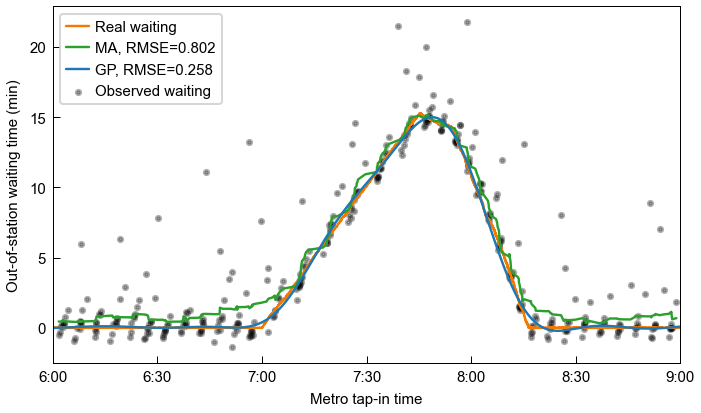

In [4]:
# Visulaize result
limits = [0, 180]
fig, ax = plt.subplots(figsize=(5, 3))
model.plot_data(ax=ax, marker='o', s=4.5, alpha=0.3, linewidths=0, label='Observed waiting')
# model.plot_confidence(plot_limits=limits, ax=ax, plot_raw=True, label='GP conficence')
ax.plot(data['metro_entering'].values, data.true_waiting, color='#f57900', label='Real waiting', linewidth=1.2)
ax.plot(t_array, w_array, '-',color='C2', label='MA, RMSE=0.802', linewidth=1.2)
model.plot_mean(plot_limits=limits, ax=ax, label='GP, RMSE=0.258', linewidth=1.2, color='C0')

ax.legend(loc='upper left')
ax.set_xlabel('Metro tap-in time')
ax.set_ylabel('Out-of-station waiting time (min)')
# ax.set_ybound([-5, 29])
ax.set_xbound(limits)
ax.set_xticks([0, 30, 60, 90, 120, 150, 180])
ax.set_xticklabels(['6:00', '6:30', '7:00', '7:30', '8:00', '8:30', '9:00'])
fig.set_tight_layout(0.1)

In [5]:
# Calculate RMSE
time_enter = data.metro_entering.values
GP_mean = model.predict(time_enter[:,None])
GP_mean = GP_mean[0].ravel()
MA = np.array([average_value(t_series=t_series,
                             w_series=w_series, 
                             t=ti,
                             n=15, include_same_value=False) for ti in time_enter])
truth = data.true_waiting
RMSE = lambda x, y: np.mean((x-y)**2)**0.5
print(RMSE(truth, GP_mean))
print(RMSE(truth, MA))

0.2579473632683609
0.8021329650758137


In [6]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jan 24 2022

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

matplotlib: 3.3.3
pandas    : 1.2.1
GPy       : 1.9.9
numpy     : 1.20.1

Watermark: 2.3.0

